# Part 05 - Pandas applied for stock market analysis

One of the most interesting uses of python is as a data analysis system. Its plotting tools are top notch and along with libraries such as pandas there are a wealth of statistical analysis tools available. Pandas is like excel on steroids so it's well worth learning.

For a more complete look at data analysis using pandas, see [this example working through earth science data](https://www.scipy-lectures.org/intro/scipy.html#statistics-and-random-numbers-scipy-stats). I have a personal interest in stocks and shares and I'm an avid fan of SpaceX and Tesla, so lets look at some data on Tesla.

<b>Note</b>: `pandas_datareader` is a web scraping tool. Website owners don't always like this so they often "accidentally" break its functionality. I have to rewrite this example every year as the datasource and its format change. It also doesn't always run on all of my (5) computers as you need the latest pandas and pandas_datareader. I only guarantee it will work on the online notebooks in July. 

This is typical of web scraping applications.

In [2]:
# Pandas is like a programmable spreadsheet, you have named columns of data and an index
import pandas as pd
# This next line is needed to fix a current bug in pandas_datareader
pd.core.common.is_list_like = pd.api.types.is_list_like
# Pandas datareader is an interface to lots of kinds of sources of data, including stocks
import pandas_datareader.data as web

# Websites limit the rate at which you can download stock data. Here we check if we've
# already downloaded the data and pickled it as "stock_data.p"
import pickle
import os.path
if not os.path.isfile("stock_data.p"):
    # OK we've not downloaded it yet, download the data then pickle it
    
    # Let's get Tesla stock data; Tesla's ticker symbol is TSLA on the US NASDAQ exchange
    # First argument is the series we want, second is the source ("yahoo" works at the moment)
    tsla = web.DataReader("TSLA.US", "stooq")

    # We'll also extract the Standard & Poor 500 index (sum of the top 500 US companies)
    sapx = web.DataReader("^SPX", "stooq")
    
    outfile = open("stock_data.p", "wb")
    pickle.dump([tsla, sapx], outfile) #save tesla and S&P indeX
else:
    # We've already downloaded it, just unpickle it
    infile = open("stock_data.p", "rb")
    tsla, sapx = pickle.load(infile)

#What kind of data did we get? Lets print the header of the table and the first few rows
print(tsla.tail())

              Open    High     Low   Close    Volume
Date                                                
2016-07-18  43.928  45.418  43.660  45.250  14470075
2016-07-15  44.504  44.550  43.928  44.074   8920765
2016-07-14  44.624  44.988  44.210  44.306  10951865
2016-07-13  45.100  45.118  44.058  44.506  14428805
2016-07-12  44.820  45.500  44.644  44.930  20020975
               Open     High      Low    Close      Volume
Date                                                      
2016-07-18  2162.04  2168.35  2159.63  2166.89  1671838889
2016-07-15  2165.13  2169.05  2155.79  2161.74  1734777778
2016-07-14  2157.88  2168.99  2157.88  2163.75  1925338889
2016-07-13  2153.81  2156.45  2146.21  2152.43  1945733333
2016-07-12  2139.50  2155.40  2139.50  2152.14  2276566667


Great, opening and closing prices as well as daily highs/lows and the volume of stocks traded, all indexed by the date of the information. Notice that some dates are missing (weekends/holidays). This is noisy data, not all indexes are there in each dataset, and some data points are completely invalid, just like real experimental data!

We need a basis for comparison for the performance of an individiual stock, so we also downloaded the S&P 500 index (the average of the 500 largest companies on the index).

In [3]:
print(sapx.tail())

               Open     High      Low    Close      Volume
Date                                                      
2016-07-18  2162.04  2168.35  2159.63  2166.89  1671838889
2016-07-15  2165.13  2169.05  2155.79  2161.74  1734777778
2016-07-14  2157.88  2168.99  2157.88  2163.75  1925338889
2016-07-13  2153.81  2156.45  2146.21  2152.43  1945733333
2016-07-12  2139.50  2155.40  2139.50  2152.14  2276566667


OK, let's try plotting the data and comparing tesla versus the index,

<AxesSubplot:xlabel='Date'>

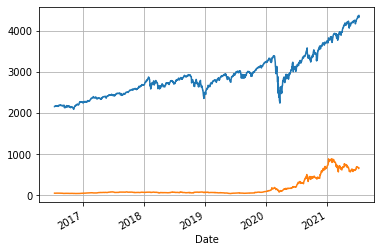

In [12]:
%matplotlib inline
#Pandas has its own built in support for matplotlib:
sapx["Close"].plot(grid = True) # Plot the closing price of S&P 500
tsla["Close"].plot(grid = True) # Plot the closing price of Tesla

Hmmmm... Lets filter that data, only taking back as far as the start of 2016. Here we see the power of pandas' slicing,

<AxesSubplot:xlabel='Date'>

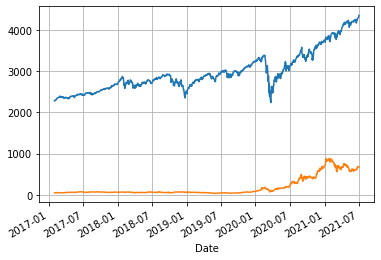

In [17]:
import datetime
#Lets set some dates, note the start/end are backwards as the data is ordered newest to oldest
end = datetime.datetime(2017,2,1)
start = datetime.datetime(2021,7,4)

#This demonstrates the power of pandas, 2021/7/4 is a Sunday
#so there's no market data but it just grabs all points within that timeframe. It does the "smart" thing, instead of complaining the dates are bad.
sapx.loc[start:end]["Close"].plot(grid = True)
tsla.loc[start:end]["Close"].plot(grid = True)

Hmm, still not a good comparison due to the differing scale of the symbols, lets try normalising both curves by the starting value,

<AxesSubplot:xlabel='Date'>

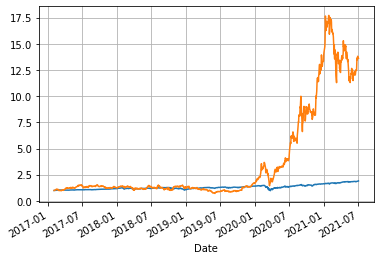

In [19]:
# Get the index of the datapoints closest to the start date
sapx_idx_start = sapx.index.get_loc(end, method='nearest')
tsla_idx_start = tsla.index.get_loc(end, method='nearest')

# Now divide all data by the closing price on that date and plot
(sapx.loc[start:end]["Close"] / sapx.iloc[sapx_idx_start]["Close"]).plot(grid = True)
(tsla.loc[start:end]["Close"] / tsla.iloc[tsla_idx_start]["Close"]).plot(grid = True)

Nice! Pandas lets us just divide lists of data by scalars by just applying the division element-wise across the array. I didn't actually know pandas could do this, I just tried the simplest thing and it worked. Python libraries are terrific at Just Working&trade;. We can see that over this time period, Tesla actually performed almost exactly to market  until 2020-01 but with significantly higher volatility. When I started teaching python, the lesson the data gave was that investing in the market as an average was the safer bet. Now, this just points to something crazy happening in the market.

Let's actually normalise to the S&P 500 index every day (instead of just the value today), to see the fluctuation around the index a bit clearer,

<AxesSubplot:xlabel='Date'>

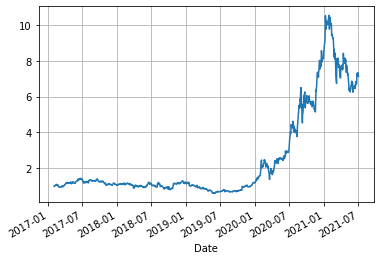

In [22]:
starting_ratio = tsla.iloc[tsla_idx_start]["Close"] / sapx.iloc[sapx_idx_start]["Close"]

data = tsla.loc[start:end]["Close"]/sapx.loc[start:end]["Close"] / starting_ratio
data.plot(grid = True)

Warren Buffet (famous american investor, 3rd wealthiest person in the world), made a  \$1M bet that a low-cost S&P 500 index tracker (simple fund that invests in all the companies in the index) would outperform highly managed index funds over 10 years. He won this bet when the index tracker made 7% annual and the hedge funds made 2.2%. The primary difference was the fees charged for management.

This is anecdotal evidence that even stocks that have performed amazingly at times (like tesla) still average out to the index. If you'd just invested in the S&P 500 index, you'd have the same returns on average, but a lot less fluctuation/heart-attacks! (Note, this is now out of date after 2020-01, tesla has exploded...)

Of course, this is not investment advice or even a particularly detailed analysis; however, it shows just how easy it is to get data into python and hack something interesting out of it. 

## Extra credit

For more information on analysing data sets, see this earth science example mentioned in the introduction:
http://earthpy.org/pandas-basics.html


- What day of the week is the best day to buy stocks? Just take all data for the week, normalise it by Monday's value, and then plot the average value over the rest of the week. You can extract the day of the week using commands like `tesla.iloc[idx]['Date'].dt.dayofweek`].
- Extend this to months. Are there annual cycles? Can you find the patterns to the stock market? Watch out for red herrings, like stock prices dropping as soon as the company issues a dividend. If you solve this one, there's many bankers who want to talk to you...
- Grab Tensorflow and train an AI ANN to trade stocks, make your first million before you're my age.